# Models

In [1]:
from numpy import newaxis
from seaborn import set as sns_set
from seaborn import FacetGrid, heatmap
from scipy import stats
from sklearn.cross_validation import train_test_split
from sklearn import grid_search, metrics

from util.dfmgmt import initSet, wrangle, dropOutliers
from util.polarize import *

In [2]:
sns_set(style="whitegrid", font_scale=1)
%matplotlib inline

target = 'charted'  # main feature to be predicted
features = ['density', 'unique_words', 'sentiment_polarity', 'explicit']  # best features

In [3]:
df = initSet()

In [4]:
# Check head
df.head()

,year,decade,unique_words,density,unique_words_raw,density_raw,nouns,verbs,adjectives,syllables,most_used_term,most_used_freq,explicit,total_curses,reading_score,sentiment,charted
0,1961,1960,36,72,65,158,34,30,10,70,rose,7,0,0,2.367848,0.9901,0
1,1961,1960,45,91,74,197,45,37,19,81,name,6,0,0,2.771777,0.9712,1
2,1961,1960,54,103,88,223,45,48,17,98,babi,10,0,0,3.885650,0.9974,1
3,1961,1960,42,148,66,263,81,61,36,76,love,24,0,0,2.889886,0.9993,1
4,1961,1960,28,131,60,354,56,77,5,57,come,38,0,0,2.940000,0.9812,1


### Build model without time

In [5]:
df['sentiment_polarity'] = df.apply(sentiment, axis=1)  # classify sentiment score

In [6]:
# Drop both year and decade
dropList = ['most_used_term', 'reading_score', 'sentiment',
            'year', 'decade']
removeList = ['charted']

df_new = wrangle(df, dropList, removeList)

In [7]:
from sklearn import linear_model

# set X and y and build model
X = df_new[features]
y = df_new[target]

# Create separate training and test sets with 60/40 train/test split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=1000
)

# train model with classifier and parameter determined best by
# 
model = linear_model.LogisticRegression(C=1)
model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
# Evaluate accuracy of model on test set
print "Accuracy of training set: %0.3f" % model.score(X_train, y_train)
print "Accuracy of test set: %0.3f" % model.score(X_test, y_test)

# Evaluate ROC AUC score of model on test set
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

Accuracy of training set: 0.688
Accuracy of test set: 0.675
ROC AUC: 0.718


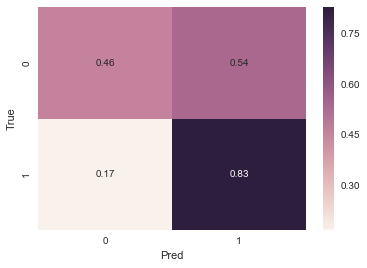

In [9]:
# Get confusion matrix on test set
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, newaxis]

ax = plt.axes()
heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

In [10]:
df_test = X_test
df_test['probability'] = model.predict_proba(X_test).T[1]
df_test[target] = y_test

/home/sabbir/anaconda2/envs/venv/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/sabbir/anaconda2/envs/venv/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [11]:
df_test = dropOutliers(df_test, 1.5)

In [12]:
df_test.head(10)

,density,unique_words,sentiment_polarity,explicit,probability,charted
146,53,21,1,0,0.569406,1
832,99,38,1,0,0.651494,1
1006,108,56,1,0,0.612130,1
1499,125,82,1,0,0.566028,0
670,54,29,1,0,0.540828,1
1587,152,54,1,0,0.746953,1
801,124,65,1,0,0.628740,1
1677,126,52,1,0,0.682185,1
30,85,36,1,0,0.615141,1
1919,124,42,1,0,0.710620,0


In [13]:
df_test['probability'].describe()

count    1313.000000
mean        0.592002
std         0.128413
min         0.307059
25%         0.512479
50%         0.598008
75%         0.685147
max         0.839206
Name: probability, dtype: float64

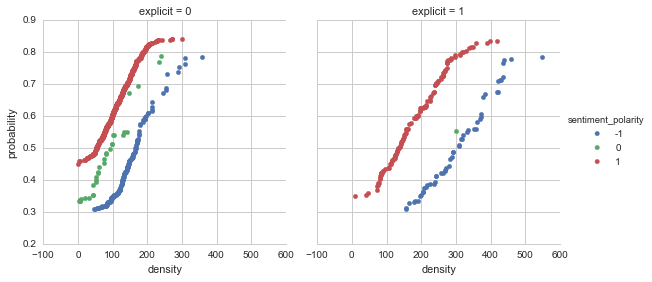

In [14]:
def qqplot(x, y, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    plt.scatter(xr, yr, **kwargs)

g = FacetGrid(df_test, col='explicit', hue='sentiment_polarity', size=4)
g.map(qqplot, 'density', 'probability')
g.add_legend();